# Deep Learning - **Homework #5**

* Teching assistant email: trung@uef.fi
* Deadline: **23:59 - 14/12/2019 (UPDATED)**
* Maximum: **4 points**

Goals:

* Understand the convolutional arithmetic: convolutional operator in 1D and 2D domains, transposed convolution, pooling operators.
* Understand how deep neural networks could see the "invisible" signal, and learning the temporal association between the past and the future.
* Understand the deconvolution (a.k.a transposed convolution) operator and its role in the rise and fall of Generative Adversarial Network (GAN).

References:

1.  Dumoulin, V., Visin, F. (2016). [A guide to convolution arithmetic for deep learning](https://github.com/vdumoulin/conv_arithmetic).
2. Araujo, et al. (2019) [Computing Receptive Fields of Convolutional Neural Networks](https://distill.pub/2019/computing-receptive-fields/), Distill Pub.
3. Boureau, Y., Ponce, J., LeCun, Y. (2010). [A theoretical analysis of feature pooling in visual recognition](https://www.di.ens.fr/willow/pdfs/icml2010b.pdf). In Proceedings of the 27th International Conference on International Conference on Machine Learning (ICML'10).
4. Zeiler, M. D., Krishnan, D., Taylor, G. W., & Fergus, R. (2010). [Deconvolutional networks](https://www.matthewzeiler.com/mattzeiler/deconvolutionalnetworks.pdf). In 2010 IEEE Computer Society Conference on Computer Vision and Pattern Recognition, CVPR 2010
5. Radford, A., Metz, L., Chintala, S. (2015). [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks (DCGAN)](https://arxiv.org/abs/1511.06434)
6. Crissman Loomis (2019). [CNNs Are Broken — How to Fix Them](https://medium.com/@crissmanloomis/cnns-are-broken-how-to-fix-them-b0bd48b98a24)
7. Quanta Magazine [Where We See Shapes, AI Sees Textures](https://www.quantamagazine.org/where-we-see-shapes-ai-sees-textures-20190701)
8. Ngo, T.T. (2017).[A comprehensive deep learning approach to end-to-end language identification](http://epublications.uef.fi/pub/urn_nbn_fi_uef-20170270/urn_nbn_fi_uef-20170270.pdf)
9. Ian Goodfellow (2016). [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160)
10. Paradis, P. (2017). [Training GANs better understanding and other improved techniques](https://philparadis.wordpress.com/2017/04/24/training-gans-better-understanding-and-other-improved-techniques/)
11. Oord, A., Dieleman, S., et al. (2016). [WaveNet: A Generative Model for Raw Audio](https://arxiv.org/abs/1609.03499)
12. Bai, Z., Kolter, J.Z., Koltun, V. (2018).[An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling](https://arxiv.org/abs/1803.01271)



How to submit:

* Option#1: **File** $\to$ **Download .ipynb** $\to$ _Send to .ipynb file to my email, or submit it to moodle page_.
* Option#2: **Share** read-only notebook link to my email.
* _If you choose to share the notebook, please re-name the notebook to your student name and student number, I will take the snapshot of your notebook before the deadline, any modification afterward will be disregarded._

**NOTE**: This is official homework and will be graded

In [0]:
%tensorflow_version 2.x
%matplotlib inline
import os
import time
from collections import defaultdict

import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow_datasets as tfds
from IPython import display

sns.set()
mnist = tfds.load('mnist')
fmnist = tfds.load('fashion_mnist')

# Question 1: Learning the Association via Local Receptive Field

To understand the convolution operator, visit `[1]`. A fast visualization is provided here:

* The blue boxes are input
* The cyan boxes are output
* The grey moving boxes are kernel, weight or filter

![alt text](https://drive.google.com/uc?export=view&id=14H-kAU0jQnnqekZaJ8NS1YL4OEDFPfKt)

_If you are still confusing about the convolutional operators, scroll to the end of this homework_


## **a)** Read and run the following code block, explain how we prepare the input image for convolutional neural network.

* Shuffle the training set prevent the model from explicitly remembering the data order, in other words, successive training examples rarely belong to the same class which doen't bias the training progress toward optimial region for specific case.
* Scaling improves convergence speed and accuracy
* Centering fights vanishing and exploding gradients, while probably also increasing convergence speed and accuracy

In [0]:
def process_image(data):
  r""" [0,255] -> [-1, 1]"""
  img = data['image']
  lab = data['label']
  img = (tf.cast(img, tf.float32) / 255.0 - 0.5) * 2.0
  return img, lab

def create_image_dataset(ds, batch_size=256, training=None):
  if training:
    ds = ds.shuffle(int(1e3))
  ds = ds.batch(batch_size).map(process_image).prefetch(
      tf.data.experimental.AUTOTUNE)
  return ds

train = create_image_dataset(mnist['train'], batch_size=256, training=True)
test = create_image_dataset(mnist['test'], batch_size=256, training=False)

image_shape = tf.data.experimental.get_structure(train)[0].shape[1:]
print("Image shape:", image_shape)

Image shape: (28, 28, 1)


## **b)** Create a convolutional neural network and achieve > 98% accuracy on MNIST test set.

In [0]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=image_shape),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])
# print(model.summary())
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
n_epoch = 12
model.fit(x=train.repeat(n_epoch))
model.evaluate(test)

2820/2820 [==============================] - 209s 74ms/step - loss: 0.0623 - accuracy: 0.9819
     40/Unknown - 2s 45ms/step - loss: 0.0525 - accuracy: 0.9870

[0.052526495658094065, 0.987]

## **c)** Create a deep convolutional neural network satisfying the following description.


```
Input_shape: (None, 28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 128)         204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
=================================================================
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0
```



In [0]:
print("Input_shape:", (None,) + image_shape)
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=image_shape),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(64, 3, strides=2, activation='relu'),
    keras.layers.Conv2D(128, 5, padding='valid', activation='relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])
print(model.summary())

Input_shape: (None, 28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 128)         204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)        

# Question 2: 1D-Convolution, Temporal and Causal Convolution for Sequencial Signal

In [0]:
#@title Run this block, functions for loading and preparing audio signals
def load_fsdd():
  import zipfile
  url = 'https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.8.zip'
  path = keras.utils.get_file('fsdd.zip', url)
  outpath = os.path.join(os.path.dirname(path), 'fsdd')
  if not os.path.exists(outpath):
    with zipfile.ZipFile(path, 'r') as zf:
      zf.extractall(outpath)
  outpath = os.path.join(outpath, 'free-spoken-digit-dataset-1.0.8/recordings')
  all_files = [os.path.join(outpath, f) for f in os.listdir(outpath)]
  np.random.shuffle(all_files)
  return all_files


mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=40,
    num_spectrogram_bins=257,
    sample_rate=8000,
    lower_edge_hertz=125.0,
    upper_edge_hertz=3800.0)


def wav2spec(path, mel_scale=True):
  name = tf.strings.split(tf.strings.split(path, '/')[-1], '_')
  digit = tf.strings.to_number(name[0], tf.float32)
  speaker = name[1]
  f = tf.io.read_file(path)
  y, sr = tf.audio.decode_wav(f)
  y = y[:, 0]  # only first channel
  sr = tf.cast(sr, tf.float32)
  s = tf.signal.stft(y,
                     frame_length=tf.cast(0.025 * sr, tf.int32),
                     frame_step=tf.cast(0.005 * sr, tf.int32),
                     fft_length=512)
  if mel_scale:
    spec = tf.tensordot(tf.abs(s), mel_weight_matrix, 1)
  else:
    spec = tf.pow(tf.abs(s), 2)
  spec = tf.math.log(spec + 1e-6)
  return y, spec, digit, speaker


def create_audio_dataset(filelist, batch_size=32, max_length=300,
                         training=None):

  def process(path):
    y, spec, digit, speaker = wav2spec(path)
    return spec, digit

  def maxlength(X, y):
    return X[:max_length], y

  ds = tf.data.Dataset.from_tensor_slices(filelist)
  if training:
    ds = ds.shuffle(100)
  ds = ds.map(process)
  structure = tf.data.experimental.get_structure(ds)
  n_features = structure[0].shape[1]
  ds = ds.cache().map(maxlength).padded_batch(
      batch_size,
      padded_shapes=([max_length,
                      n_features], [])).prefetch(tf.data.experimental.AUTOTUNE)
  return ds

### **a)** Signal processing, _unravelling the intangible_

* Explain the different between raw waveform and the spectrogram of the audio
* Could you recognize a specific pattern in the audio signal that is relevant to distinguish number 1 or 8
* What is the different between the number 8 image (from MNIST), and the number 8 "image" (from FSDD)?
* What is the main issue when we applying convolution network to the spectrogram of audio signal?

Step-by-step for processing audio signal is in Chapter 2, `[8]`

---

* The raw waveform tick at greater rate, in other words, it change faster so the pattern is not easy recognized. It is also more sensitive to confounding factors (speaker, recording device, gender, age ...). The spectrogram illustrate speech in frequency-time domain, it emphasizes the magnitude of speech as different frequency and different position in time. Looking at the spectrogram, we could guess how the speech changing overtime.
* Number 8 has more power in the upper middle of the frequency range
* It is harder to recognize number 8 from spectrogram image. Speech is more diverse.
* Speech signal encapsulates temporal pattern. Some speech pattern could be "skipped" in frequency domain, i.e. low frequency is correlated with high frequency without going through middle frequency.

7241728/Unknown - 3s 0us/step

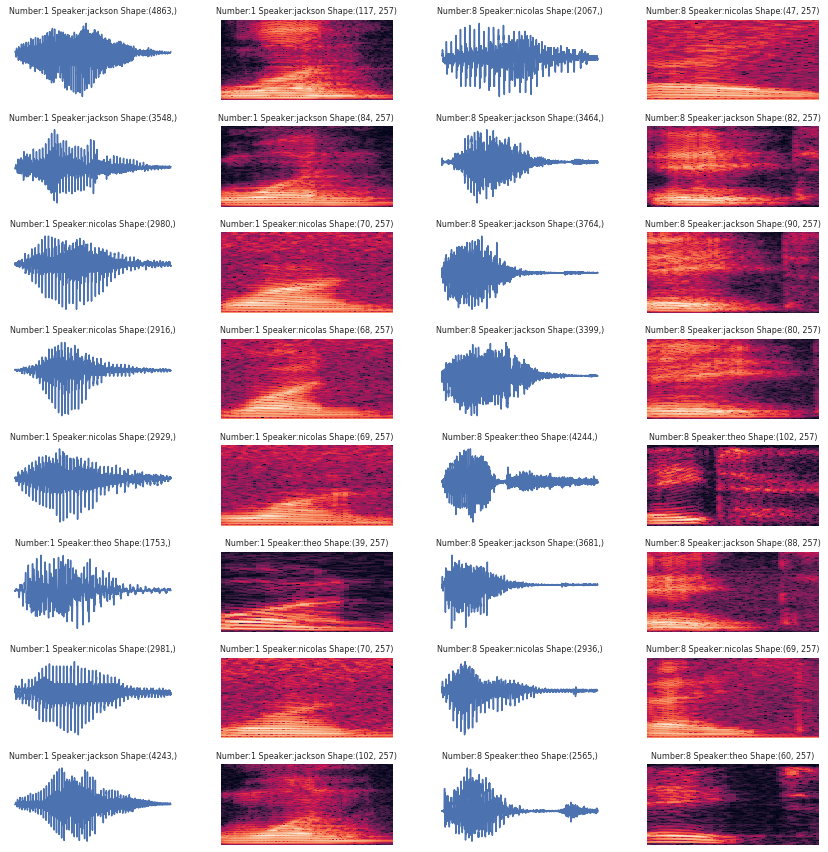

In [0]:
#@title Run this block to see the plot, and answer the above questions
fsdd = load_fsdd()
np.random.shuffle(fsdd)

files1 = [i for i in fsdd if os.path.basename(i).split('_')[0] == '1']
files8 = [i for i in fsdd if os.path.basename(i).split('_')[0] == '8']
data1 = [wav2spec(i, mel_scale=False) for i in files1[:8]]
data8 = [wav2spec(i, mel_scale=False) for i in files8[:8]]
n = len(data1)

plt.figure(figsize=(12, 12))
for i, (d1, d8) in enumerate(zip(data1, data8)):
  plt.subplot(n, 4, i * 4 + 1)
  plt.plot(d1[0])
  plt.axis('off')
  plt.title("Number:%d Speaker:%s Shape:%s" % (d1[2].numpy(), str(d1[3].numpy(), 'utf-8'), d1[0].shape),
            fontsize=8)

  ax = plt.subplot(n, 4, i * 4 + 2)
  ax.pcolorfast(d1[1].numpy().T)
  plt.axis('off')
  plt.title("Number:%d Speaker:%s Shape:%s" % (d1[2].numpy(), str(d1[3].numpy(), 'utf-8'), d1[1].shape),
            fontsize=8)

  plt.subplot(n, 4, i * 4 + 3)
  plt.plot(d8[0])
  plt.axis('off')
  plt.title("Number:%d Speaker:%s Shape:%s" % (d8[2].numpy(), str(d8[3].numpy(), 'utf-8'), d8[0].shape),
            fontsize=8)

  ax = plt.subplot(n, 4, i * 4 + 4)
  ax.pcolorfast(d8[1].numpy().T)
  plt.axis('off')
  plt.title("Number:%d Speaker:%s Shape:%s" % (d8[2].numpy(), str(d8[3].numpy(), 'utf-8'), d8[1].shape),
            fontsize=8)

_ = plt.tight_layout()

## **b)** Create a convolutional neural network to recognize 10 different spoken digit.

Achieve > 90% accuracy on test set.

In [0]:
# This code select 80% of audio files for training
# and the rest (20%) for testing
# If you want to know how is the sequence data (e.g. audio, text) is preprocessed, read function "create_audio_dataset" (optional)
train_files = fsdd[:int(0.8 * len(fsdd))]
test_files = fsdd[int(0.8 * len(fsdd)):]

train = create_audio_dataset(train_files, training=True)
test = create_audio_dataset(test_files, training=False)
input_shape = tf.data.experimental.get_structure(train)[0].shape[1:]
print("Input shape:", input_shape) # (time_dim, feature_dim)

Input shape: (300, 40)


In [0]:
model = keras.Sequential([
    keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, 3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(128, 3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])
#print(model.summary())
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
n_epoch = 12
model.fit(x=train.repeat(n_epoch))
model.evaluate(test)

Train for 456 steps
10/10 [==============================] - 2s 169ms/step - loss: 0.1616 - accuracy: 0.9767


[0.16159578915685416, 0.9766667]

## **c)** What does convolutional network actually learn?

Run the following code block to re-split the dataset, then try to achieve 90% on test set!

* Could you explain what is the difference in this spliting scheme?
* Explain the output of the network in this case?

We split the data by speakers, in speech processing, the test set must contain an exclusive of speaker.

Otherwise, the model will remember speaker detail instead of the desire pattern.

In [0]:
all_speakers = np.unique([os.path.basename(i).split('_')[1] for i in fsdd])
np.random.shuffle(all_speakers)
train_speakers = all_speakers[:2]
test_speakers = all_speakers[2:]
print("All   speakers:", all_speakers)
print("Train speakers:", train_speakers)
print("Test  speakers:", test_speakers)

train_files = [
    i for i in fsdd if os.path.basename(i).split('_')[1] in train_speakers
]
test_files = [i for i in fsdd if i not in train_files]

train = create_audio_dataset(train_files, training=True)
test = create_audio_dataset(test_files, training=False)

All   speakers: ['jackson' 'nicolas' 'theo']
Train speakers: ['jackson' 'nicolas']
Test  speakers: ['theo']


In [0]:
model = keras.Sequential([
    keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64, 3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(128, 3, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])
#print(model.summary())
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
n_epoch = 12
model.fit(x=train.repeat(n_epoch))
model.evaluate(test)

Train for 384 steps
16/16 [==============================] - 3s 164ms/step - loss: 3.4752 - accuracy: 0.5540


[3.4752057790756226, 0.554]

# Question 3: Implementing Deep Convolutional GAN

Architecture guidelines for stable Deep Convolutional GANs `[5]`:

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use `ReLU` activation in generator for all layers except for the output, which uses `Tanh`.
* Use `LeakyReLU` activation in the discriminator for all layers.

Base on this guideline, create a generator for the following GAN network to achieve reasonable fashion image.

---
To understand the transposed convolution operator (a.k.a deconvolution), visit `[1]`. A fast visualization is provided here:

* The blue boxes are input
* The cyan boxes are output
* The grey moving boxes are kernel, weight or filter

![alt text](https://drive.google.com/uc?export=view&id=1YlUML3X_p53Tk9dBOyhM5sUd0k7QHJ0W)



In [0]:
#@title Run this block to prepare the Fashion-MNIST data
def deprocess(img):
  r""" [-1, 1] -> [0,255] """
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)


def process(data):
  r""" [0,255] -> [-1, 1]"""
  img = tf.cast(data['image'], tf.float32)
  lab = data['label']
  img = (img / 255.0 - 0.5) * 2.0
  return img


BATCH_SIZE = 256
train = fmnist['train'].shuffle(10000).batch(BATCH_SIZE).map(process).prefetch(
    tf.data.experimental.AUTOTUNE)
img_shape = tf.data.experimental.get_structure(train).shape[1:]
print("Image shape:", img_shape)

Image shape: (28, 28, 1)


In [0]:
def make_generator(noise_dim, img_shape):
  height, width, channels = img_shape
  assert height % 4 == 0 and width % 4 == 0
  return keras.Sequential([
      keras.layers.Dense(height // 4 * width // 4 * 128,
                         use_bias=False,
                         input_shape=(noise_dim,)),
      keras.layers.BatchNormalization(),
      keras.layers.ReLU(),
      keras.layers.Reshape((height // 4, width // 4, 128)),
      keras.layers.Conv2DTranspose(
          64, (5, 5), strides=(1, 1), padding='same', use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.ReLU(),
      keras.layers.Conv2DTranspose(
          32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.ReLU(),
      keras.layers.Conv2DTranspose(channels, (5, 5),
                                   strides=(2, 2),
                                   padding='same',
                                   use_bias=False,
                                   activation='tanh')
  ],
                          name="Generator")


def make_discriminator(img_shape):
  return keras.Sequential([
      keras.layers.Dropout(0.3),
      keras.layers.Conv2D(32, (5, 5),
                          strides=(2, 2),
                          padding='same',
                          input_shape=img_shape,
                          use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),
      keras.layers.Conv2D(
          64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.LeakyReLU(),
      keras.layers.Flatten(),
      keras.layers.Dense(1),
  ],
                          name="Discriminator")

**Some personal notes on training GAN** (further reading `[9]`):

* Our goal is to generate good image, i.e. good enough to fool the _discriminator_. Hence, if we get an "idiot" _discriminator_, it results a pointless _generator_. As a results, one of the prerequisites of GAN is an optimal _discriminator_, in the other words, the discriminator loss should be smaller than generator loss. But ...
* The goal of GAN is neither optimizing _discriminator_ nor _generator_. We want to reach the _equilibrium state_ when both player playing an optimal game. This means both generator and discriminator loss must NOT go to zero, and the game converge to a better stable process (with lower variance) in the end. Don't panic when neither of the losses going down, or they are jumping around randomly sometimes.
* GAN is very sensitive to hyperparameters: the learning rate, the choice of optimization algorithm, the network depth and number of units of discriminator and generator. Be patience, keep your learning rate down and your curiosity up, you will see something after about 20 epochs.

Anyway, running the following code block to debug your generator, read it in detail if you want to know how to train a GAN network in practice.

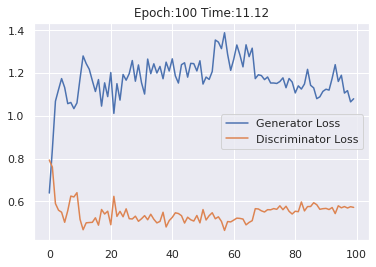

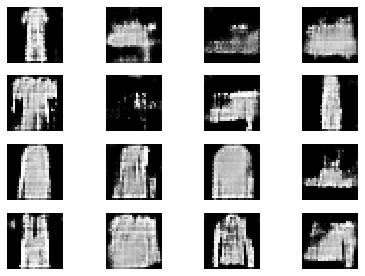

In [0]:
noise_dim = 100
G = make_generator(noise_dim, img_shape=img_shape)
D = make_discriminator(img_shape=img_shape)
#print(G.summary())
#print(D.summary())

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits


def discriminator_loss(real_output, fake_output):
  return cross_entropy(
      tf.concat([tf.ones_like(real_output),
                 tf.zeros_like(fake_output)], axis=0),
      tf.concat([real_output, fake_output], axis=0))


def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


g_optimizer = keras.optimizers.Adam(1e-4)
d_optimizer = keras.optimizers.Adam(1e-4)


@tf.function
def train_step(images):
  noise = tf.random.normal([images.shape[0], noise_dim])

  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    generated_images = G(noise, training=True)

    real_output = D(images, training=True)
    fake_output = D(generated_images, training=True)

    gen_loss = tf.reduce_mean(generator_loss(fake_output))
    disc_loss = tf.reduce_mean(discriminator_loss(real_output, fake_output))

  grad_g = g_tape.gradient(gen_loss, G.trainable_variables)
  grad_d = d_tape.gradient(disc_loss, D.trainable_variables)

  g_optimizer.apply_gradients(zip(grad_g, G.trainable_variables))
  d_optimizer.apply_gradients(zip(grad_d, D.trainable_variables))
  return gen_loss, disc_loss


seed = tf.random.normal([16, noise_dim])
g_losses = []
d_losses = []
for epoch in range(100):
  start_time = time.time()
  losses = [train_step(X) for X in train]
  g_loss = np.mean([i[0] for i in losses])
  d_loss = np.mean([i[1] for i in losses])
  g_losses.append(g_loss)
  d_losses.append(d_loss)

  display.clear_output(wait=True)
  plt.figure()
  plt.plot(g_losses, label='Generator Loss')
  plt.plot(d_losses, label='Discriminator Loss')
  plt.title("Epoch:%d Time:%.2f" % (epoch + 1, time.time() - start_time))
  plt.legend()
  plt.show()

  img = deprocess(G(seed, training=False)).numpy()
  plt.figure()
  for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i][:, :, 0], cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

Further reading in GANs if you are interested:

* GAN open question: https://distill.pub/2019/gan-open-problems/
* A Discussion of Adversarial Examples Are Not Bugs, They Are Features: https://distill.pub/2019/advex-bugs-discussion/
* Generative Adversarial Networks: An Overview: https://arxiv.org/pdf/1710.07035.pdf

# More visualization for the convolution operator

For more interactive guide and mathematical explaination `[2]`

The following figure show the detail of calculating the output for convolution:

* The left image is how a kernel and input are convoluted in single feature map. 
* The right image is how multiple feature maps are combined into final outputs.

![alt text](https://drive.google.com/uc?export=view&id=1DnSEW5JZvt3auq0lF9gSuF-oSROR34lB)

The following figure illustrates the effect of padding and striding on the output (left figure), and how max pooling is performed (right image).
![alt text](https://drive.google.com/uc?export=view&id=1UPjiCCGR2N7_A88s7aBG9zTeau2-HZKY)
